In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib as mpl
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
from astropy.convolution.kernels import CustomKernel

In [2]:
%matplotlib inline

In [3]:
plt.style.use('court.mplstyle')

In [4]:
atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-15_WISEJ194218.38-203247.5_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-15_AOHer_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-14_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-16_ATLAS.csv')
# atlas = pd.read_csv('../data/RCB_LC_FORTESTING/2023-06-19_ASAS-RCB-19_ATLAS.csv')
atlas

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57228.393173,12.691,0.003,30440.0,76.0,o,0,64.36,295.57658,-20.54653,10453.95,1565.47,3.74,3.25,80.2,-0.484,18.80,20.01,02a57228o0177o
1,57228.404176,12.700,0.002,30188.0,71.0,o,0,132.78,295.57658,-20.54653,618.20,1538.11,3.82,3.41,-64.2,-0.455,18.82,20.08,02a57228o0189o
2,57228.419211,12.748,0.002,28888.0,71.0,o,0,157.62,295.57658,-20.54653,313.04,8783.58,3.45,3.40,-41.6,-0.473,18.84,20.13,02a57228o0206o
3,57228.429475,12.729,0.002,29403.0,71.0,o,0,65.54,295.57658,-20.54653,10151.01,8809.96,3.75,3.33,-83.2,-0.451,18.85,20.15,02a57228o0218o
4,57228.451599,12.728,0.002,29433.0,73.0,o,0,124.82,295.57658,-20.54653,2602.82,553.77,3.88,3.61,-41.5,-0.453,18.96,20.34,02a57228o0243o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4611,60085.286358,15.898,0.014,1588.0,22.0,o,0,3.52,295.57660,-20.54654,3422.60,4335.45,2.14,1.93,76.5,-0.412,19.24,20.66,04a60085o0735o
4612,60085.289962,15.891,0.012,1597.0,20.0,o,0,7.68,295.57660,-20.54654,3483.49,4412.50,2.05,1.87,84.7,-0.423,19.29,20.65,04a60085o0743o
4613,60093.044580,18.811,0.103,108.0,11.0,c,0,1.20,295.57660,-20.54654,9278.83,6021.04,2.94,2.75,-33.6,-0.361,19.45,21.42,03a60093o0736c
4614,60093.047335,18.616,0.090,130.0,12.0,c,0,1.13,295.57660,-20.54654,9261.36,5982.77,2.91,2.67,-25.9,-0.358,19.48,21.42,03a60093o0742c


In [5]:
oband = atlas[atlas['f']=='o']
oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57228.393173,12.691,0.003,30440.0,76.0,o,0,64.36,295.57658,-20.54653,10453.95,1565.47,3.74,3.25,80.2,-0.484,18.80,20.01,02a57228o0177o
1,57228.404176,12.700,0.002,30188.0,71.0,o,0,132.78,295.57658,-20.54653,618.20,1538.11,3.82,3.41,-64.2,-0.455,18.82,20.08,02a57228o0189o
2,57228.419211,12.748,0.002,28888.0,71.0,o,0,157.62,295.57658,-20.54653,313.04,8783.58,3.45,3.40,-41.6,-0.473,18.84,20.13,02a57228o0206o
3,57228.429475,12.729,0.002,29403.0,71.0,o,0,65.54,295.57658,-20.54653,10151.01,8809.96,3.75,3.33,-83.2,-0.451,18.85,20.15,02a57228o0218o
4,57228.451599,12.728,0.002,29433.0,73.0,o,0,124.82,295.57658,-20.54653,2602.82,553.77,3.88,3.61,-41.5,-0.453,18.96,20.34,02a57228o0243o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4604,60079.361159,14.678,0.007,4884.0,33.0,o,0,32.80,295.57660,-20.54654,7076.95,2279.83,2.18,1.95,-19.6,-0.419,19.20,20.49,04a60079o0524o
4605,60079.384530,15.696,0.079,1912.0,150.0,o,0,0.98,295.57660,-20.54654,3581.78,8256.05,2.52,1.91,-79.3,-0.404,16.73,18.41,04a60079o0571o
4610,60085.284556,15.898,0.013,1588.0,21.0,o,0,5.27,295.57660,-20.54654,3442.06,4374.29,2.11,1.93,81.0,-0.416,19.29,20.60,04a60085o0731o
4611,60085.286358,15.898,0.014,1588.0,22.0,o,0,3.52,295.57660,-20.54654,3422.60,4335.45,2.14,1.93,76.5,-0.412,19.24,20.66,04a60085o0735o


In [6]:
oband = oband.sort_values(by=['mjd'],axis=0,ascending=True,ignore_index=True)
oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57228.393173,12.691,0.003,30440.0,76.0,o,0,64.36,295.57658,-20.54653,10453.95,1565.47,3.74,3.25,80.2,-0.484,18.80,20.01,02a57228o0177o
1,57228.393173,12.691,0.003,30460.0,76.0,o,0,65.80,295.57660,-20.54654,10453.99,1565.49,3.74,3.25,80.2,-0.484,18.80,20.01,02a57228o0177o
2,57228.404176,12.700,0.002,30194.0,71.0,o,0,130.24,295.57660,-20.54654,618.23,1538.13,3.82,3.41,-64.2,-0.455,18.82,20.08,02a57228o0189o
3,57228.404176,12.700,0.002,30188.0,71.0,o,0,132.78,295.57658,-20.54653,618.20,1538.11,3.82,3.41,-64.2,-0.455,18.82,20.08,02a57228o0189o
4,57228.419211,12.748,0.002,28888.0,71.0,o,0,157.62,295.57658,-20.54653,313.04,8783.58,3.45,3.40,-41.6,-0.473,18.84,20.13,02a57228o0206o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3301,60082.314898,15.257,0.009,2865.0,25.0,o,0,16.20,295.57658,-20.54653,5448.88,10403.51,2.60,1.82,-79.8,-0.413,19.23,20.51,04a60082o0770o
3302,60082.331080,15.234,0.010,2928.0,28.0,o,0,10.14,295.57658,-20.54653,8924.63,280.64,2.70,2.30,-31.4,-0.397,19.13,20.46,04a60082o0804o
3303,60085.284556,15.898,0.013,1588.0,21.0,o,0,5.27,295.57660,-20.54654,3442.06,4374.29,2.11,1.93,81.0,-0.416,19.29,20.60,04a60085o0731o
3304,60085.286358,15.898,0.014,1588.0,22.0,o,0,3.52,295.57660,-20.54654,3422.60,4335.45,2.14,1.93,76.5,-0.412,19.24,20.66,04a60085o0735o


In [7]:
oband = oband.drop_duplicates(subset=['mjd'],ignore_index=True) 
    # this keeps the first entry, I'd love if it took an average
oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57228.393173,12.691,0.003,30440.0,76.0,o,0,64.36,295.57658,-20.54653,10453.95,1565.47,3.74,3.25,80.2,-0.484,18.80,20.01,02a57228o0177o
1,57228.404176,12.700,0.002,30194.0,71.0,o,0,130.24,295.57660,-20.54654,618.23,1538.13,3.82,3.41,-64.2,-0.455,18.82,20.08,02a57228o0189o
2,57228.419211,12.748,0.002,28888.0,71.0,o,0,157.62,295.57658,-20.54653,313.04,8783.58,3.45,3.40,-41.6,-0.473,18.84,20.13,02a57228o0206o
3,57228.429475,12.729,0.002,29403.0,71.0,o,0,65.54,295.57658,-20.54653,10151.01,8809.96,3.75,3.33,-83.2,-0.451,18.85,20.15,02a57228o0218o
4,57228.451599,12.727,0.002,29461.0,73.0,o,0,121.64,295.57660,-20.54654,2602.78,553.75,3.88,3.61,-41.5,-0.453,18.96,20.34,02a57228o0243o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1788,60082.314898,15.257,0.009,2865.0,25.0,o,0,16.20,295.57658,-20.54653,5448.88,10403.51,2.60,1.82,-79.8,-0.413,19.23,20.51,04a60082o0770o
1789,60082.331080,15.234,0.010,2928.0,28.0,o,0,10.14,295.57658,-20.54653,8924.63,280.64,2.70,2.30,-31.4,-0.397,19.13,20.46,04a60082o0804o
1790,60085.284556,15.898,0.013,1588.0,21.0,o,0,5.27,295.57660,-20.54654,3442.06,4374.29,2.11,1.93,81.0,-0.416,19.29,20.60,04a60085o0731o
1791,60085.286358,15.898,0.014,1588.0,22.0,o,0,3.52,295.57660,-20.54654,3422.60,4335.45,2.14,1.93,76.5,-0.412,19.24,20.66,04a60085o0735o


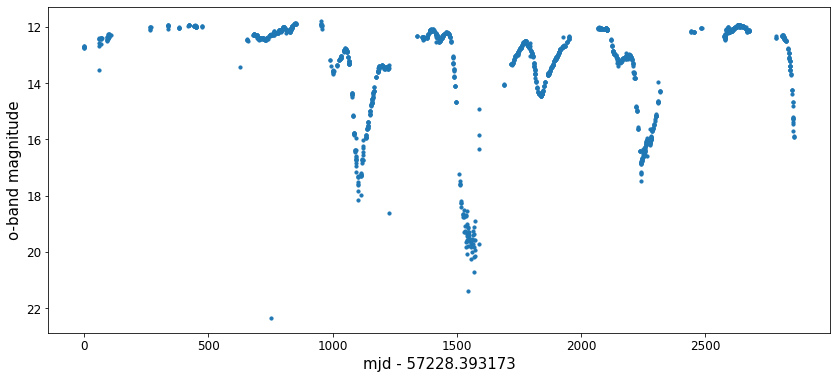

In [8]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],oband['m'],s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('o-band magnitude')
plt.show()

In [9]:
median_filtered = sp.signal.medfilt(oband['m'],kernel_size=5)

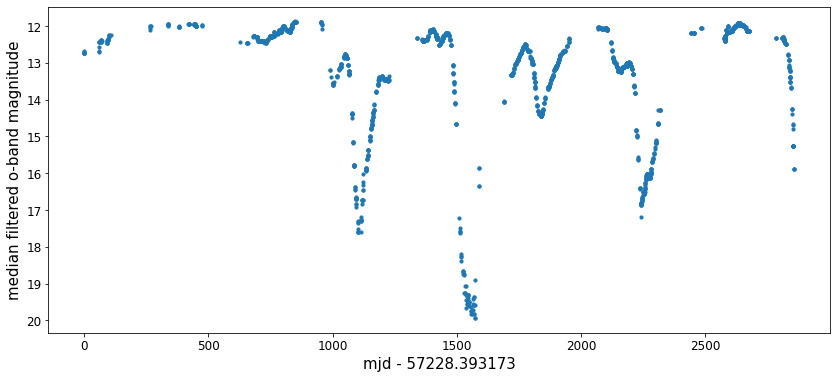

In [10]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],median_filtered,s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('median filtered o-band magnitude')
plt.show()

# Gaussian Process?

In [66]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF

In [12]:
kernel = Matern(length_scale=3, nu=3/2) + WhiteKernel(noise_level=1) #+ ConstantKernel()

In [13]:
time = np.asarray(oband['mjd']-oband['mjd'][0])
time = time.reshape(-1,1)

In [14]:
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(time, median_filtered)
# GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
#                 kernel=1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1),
#                 n_restarts_optimizer=0, normalize_y=False,
#                 optimizer='fmin_l_bfgs_b', random_state=None)

GaussianProcessRegressor(kernel=Matern(length_scale=3, nu=1.5) + WhiteKernel(noise_level=1))

In [15]:
# gp.kernel_

In [16]:
x_pred = np.linspace(0, int(np.max(time)), int(np.max(time))).reshape(-1,1)
y_pred, sigma = gp.predict(x_pred, return_std=True)

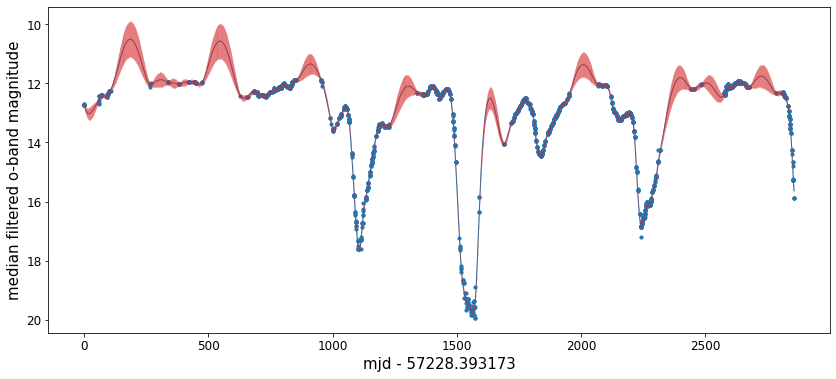

In [17]:
plt.figure(figsize=(14,6))

plt.plot(x_pred,y_pred)
plt.errorbar(x_pred, y_pred, yerr=sigma, capsize=0, color='tab:red',alpha=0.2)

plt.scatter(oband['mjd']-oband['mjd'][0],median_filtered,s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('median filtered o-band magnitude')
# plt.xlim(1000,3000)
plt.show()

### big question: what resolution should I resample to?

Probably once a night is fine, RCBs shouldn't vary much more than that??

In [18]:
# ## what time resolution? I don't want to lose any of the real data if possible
# real_resolution = np.median(np.diff(median_filtered_oband['mjd']))
# print(real_resolution)
# len_data = np.max(median_filtered_oband['mjd']-mjd_scale)
# print(len_data)
# print(len_data/(real_resolution))
# resample_time = np.linspace(0,len_data,int(len_data/(real_resolution)))#int(len_data))#int(len_data/(real_resolution/10000)))
# # ## currently resampling at a resolution of 1 day
# # # resample_flux = interpolation_function(resample_time)



gpsmoothed_time = time
gpsmoothed_flux, gpsigma = gp.predict(gpsmoothed_time, return_std=True)

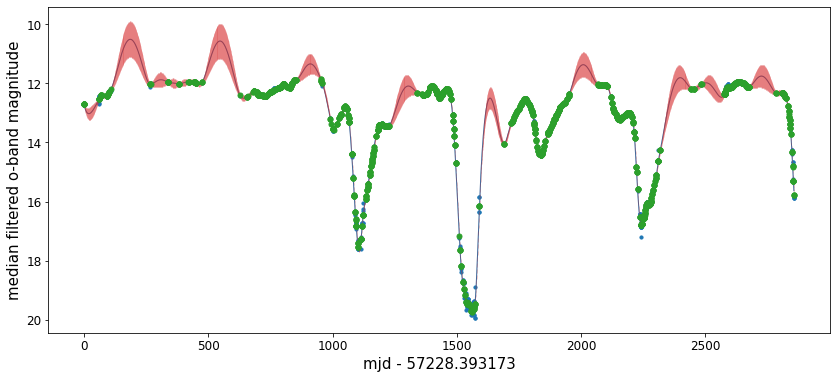

In [19]:
plt.figure(figsize=(14,6))

plt.plot(x_pred,y_pred)
plt.errorbar(x_pred, y_pred, yerr=sigma, capsize=0, color='tab:red',alpha=0.2)

plt.scatter(gpsmoothed_time,gpsmoothed_flux,color='tab:green',zorder=3)

plt.scatter(oband['mjd']-oband['mjd'][0],median_filtered,s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('median filtered o-band magnitude')
# plt.xlim(1000,3000)
plt.show()

# Back to normal

In [20]:
smoothed_flux = convolve(oband['m'], Gaussian1DKernel(20),boundary='extend')

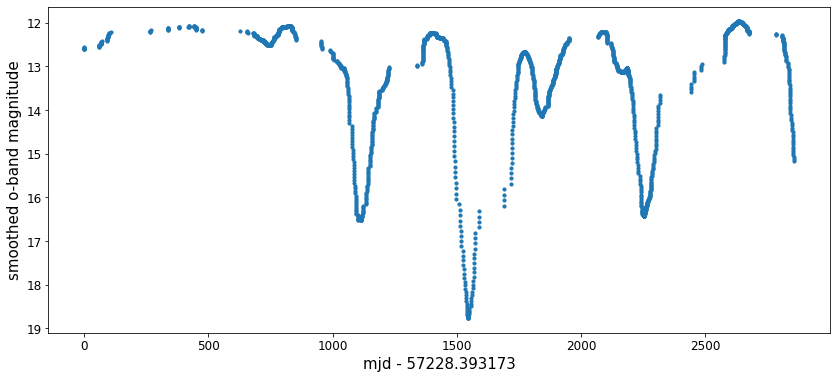

In [21]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],smoothed_flux,s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('smoothed o-band magnitude')
plt.show()

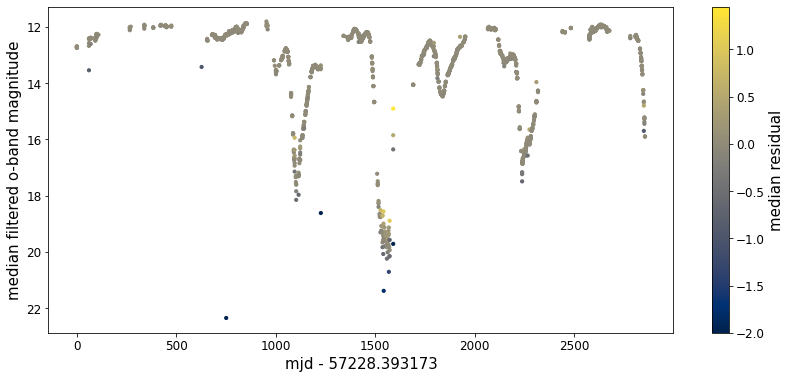

In [22]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],oband['m'],s=10,
            c=median_filtered-oband['m'],cmap='cividis')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('median filtered o-band magnitude')
plt.colorbar(label='median residual')
# plt.clim(vmax=-1)
plt.clim(vmin=-2)
plt.show()

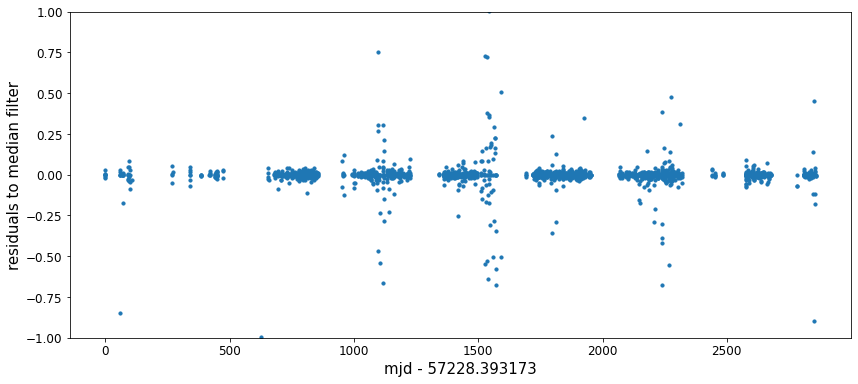

In [23]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd']-oband['mjd'][0],median_filtered-oband['m'],s=10)
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('residuals to median filter')
plt.ylim(-1,1)
plt.show()

In [24]:
mask = np.where(np.abs(median_filtered-oband['m'])<0.25,True,False)
mask

array([ True,  True,  True, ...,  True,  True,  True])

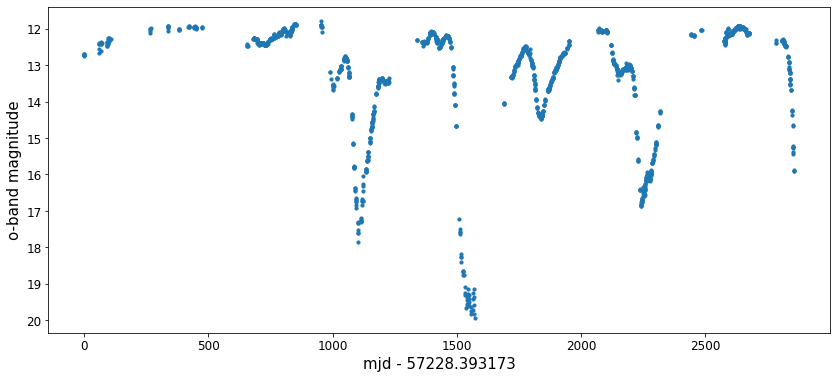

In [25]:
plt.figure(figsize=(14,6))
plt.scatter(oband['mjd'][mask]-oband['mjd'][0],oband['m'][mask],s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('o-band magnitude')
plt.show()

In [26]:
median_filtered_oband = oband.iloc[mask]
median_filtered_oband.reset_index(drop=True,inplace=True)
median_filtered_oband

,mjd,m,dm,ujy,dujy,f,err,reduced_chi,ra,dec,x,y,maj,min,phi,apfit,mag5sig,sky,obs
0,57228.393173,12.691,0.003,30440.0,76.0,o,0,64.36,295.57658,-20.54653,10453.95,1565.47,3.74,3.25,80.2,-0.484,18.80,20.01,02a57228o0177o
1,57228.404176,12.700,0.002,30194.0,71.0,o,0,130.24,295.57660,-20.54654,618.23,1538.13,3.82,3.41,-64.2,-0.455,18.82,20.08,02a57228o0189o
2,57228.419211,12.748,0.002,28888.0,71.0,o,0,157.62,295.57658,-20.54653,313.04,8783.58,3.45,3.40,-41.6,-0.473,18.84,20.13,02a57228o0206o
3,57228.429475,12.729,0.002,29403.0,71.0,o,0,65.54,295.57658,-20.54653,10151.01,8809.96,3.75,3.33,-83.2,-0.451,18.85,20.15,02a57228o0218o
4,57228.451599,12.727,0.002,29461.0,73.0,o,0,121.64,295.57660,-20.54654,2602.78,553.75,3.88,3.61,-41.5,-0.453,18.96,20.34,02a57228o0243o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738,60082.314898,15.257,0.009,2865.0,25.0,o,0,16.20,295.57658,-20.54653,5448.88,10403.51,2.60,1.82,-79.8,-0.413,19.23,20.51,04a60082o0770o
1739,60082.331080,15.234,0.010,2928.0,28.0,o,0,10.14,295.57658,-20.54653,8924.63,280.64,2.70,2.30,-31.4,-0.397,19.13,20.46,04a60082o0804o
1740,60085.284556,15.898,0.013,1588.0,21.0,o,0,5.27,295.57660,-20.54654,3442.06,4374.29,2.11,1.93,81.0,-0.416,19.29,20.60,04a60085o0731o
1741,60085.286358,15.898,0.014,1588.0,22.0,o,0,3.52,295.57660,-20.54654,3422.60,4335.45,2.14,1.93,76.5,-0.412,19.24,20.66,04a60085o0735o


In [27]:
# edge_detect = sp.ndimage.convolve(oband['m'][mask], CustomKernel([1.0, 0.0, -1.0]))
edge_detect = sp.ndimage.convolve(median_filtered_oband['m'], [1.0, 0.0, -1.0])

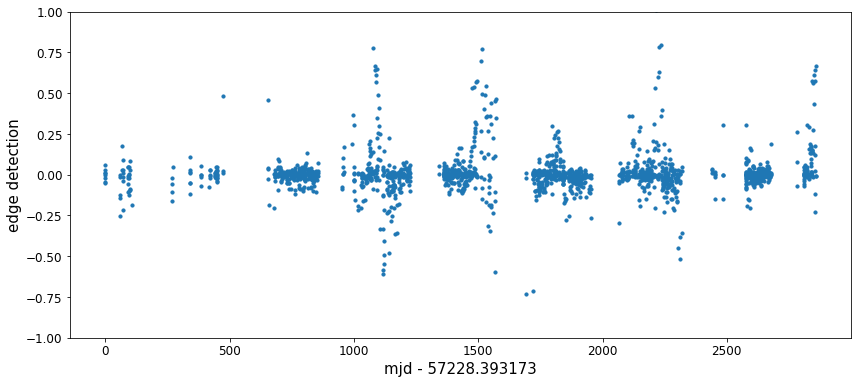

In [28]:
mjd_scale = median_filtered_oband['mjd'][0]

plt.figure(figsize=(14,6))
plt.scatter(median_filtered_oband['mjd']-mjd_scale,edge_detect,s=10)
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('edge detection')
plt.ylim(-1,1)
plt.show()

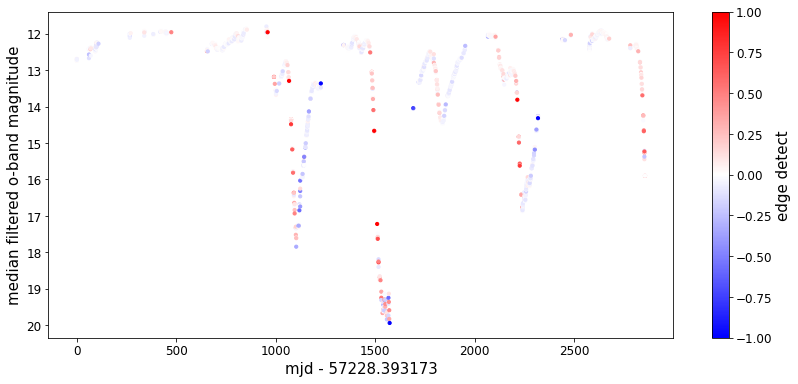

In [29]:
plt.figure(figsize=(14,6))
plt.scatter(median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m'],s=10,
            c=edge_detect,cmap='bwr')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('median filtered o-band magnitude')
plt.colorbar(label='edge detect')
# plt.clim(vmax=-1)
# plt.clim(vmin=-1)
plt.clim(-1,1)
plt.show()

### added in a gaussian smooth before the interpolation here

In [30]:
smoothed_flux = convolve(median_filtered_oband['m'], Gaussian1DKernel(20),boundary='extend')

# interpolation_function = sp.interpolate.interp1d(np.asarray(median_filtered_oband['mjd']-mjd_scale),
#                                                  np.asarray(median_filtered_oband['m']),
#                                                  kind='slinear')
interpolation_function = sp.interpolate.interp1d(np.asarray(median_filtered_oband['mjd']-mjd_scale),
                                                 np.asarray(smoothed_flux),
                                                 kind='slinear')
## what time resolution? I don't want to lose any of the real data if possible
real_resolution = np.median(np.diff(median_filtered_oband['mjd']))
len_data = np.max(median_filtered_oband['mjd']-mjd_scale)
resample_time = np.linspace(0,len_data,int(len_data))#int(len_data/(real_resolution/10000)))
## currently resampling at a resolution of 1 day
resample_flux = interpolation_function(resample_time)

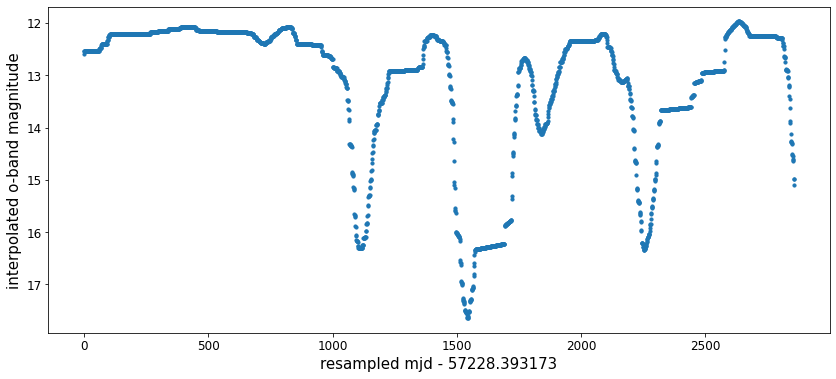

In [31]:
plt.figure(figsize=(14,6))
plt.scatter(resample_time,resample_flux,s=10)
plt.gca().invert_yaxis()
plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
plt.ylabel('interpolated o-band magnitude')
plt.show()

In [32]:
new_edge_detect = sp.ndimage.convolve(resample_flux, [1.0, 0.0, -1.0])

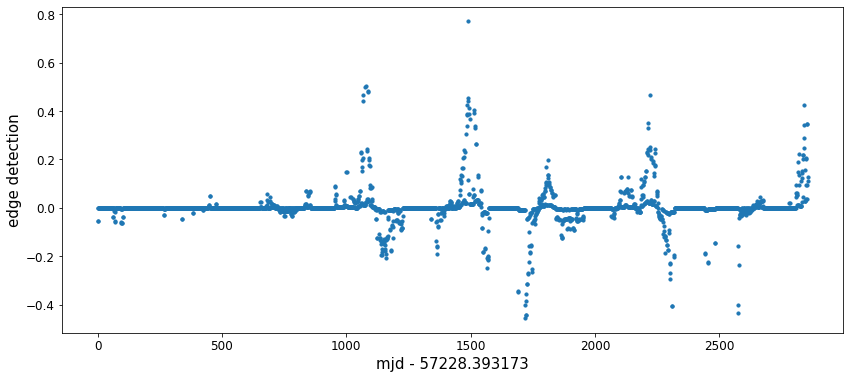

In [33]:
plt.figure(figsize=(14,6))
plt.scatter(resample_time,new_edge_detect,s=10)
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('edge detection')
# plt.ylim(-1,1)
plt.show()

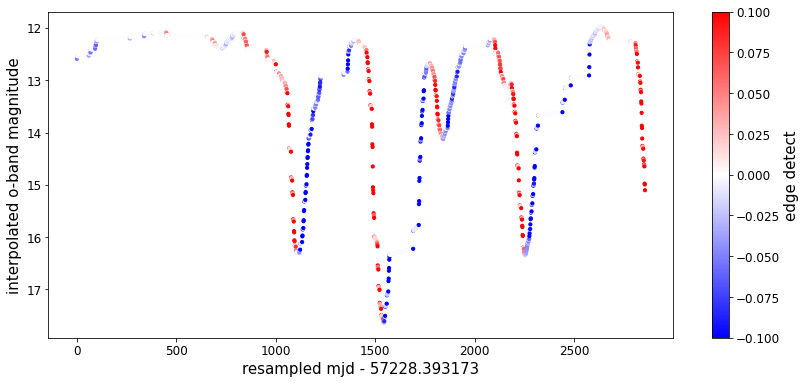

In [34]:
plt.figure(figsize=(14,6))
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.scatter(resample_time,resample_flux,s=10,
            c=new_edge_detect,cmap='bwr')#,alpha=0.2)
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.gca().invert_yaxis()
plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
plt.ylabel('interpolated o-band magnitude')
plt.colorbar(label='edge detect')
# plt.clim(vmax=-1)
# plt.clim(vmin=-1)
plt.clim(-0.1,0.1)
# lim = np.max([np.abs(np.min(new_edge_detect)),np.max(new_edge_detect)])
# plt.clim(-lim,lim)
# plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
plt.show()

# Actually all the GP stuff should go here :)

In [208]:
kernel = Matern(length_scale=3, nu=3/2) + WhiteKernel(noise_level=1) #+ ConstantKernel()
# kernel = RBF(length_scale=1,length_scale_bounds=(1e-05, 10)) + WhiteKernel(noise_level=1) #+ ConstantKernel()

In [209]:
# median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m']

time = np.asarray(median_filtered_oband['mjd']-mjd_scale)
time = time.reshape(-1,1)

In [210]:
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(time, median_filtered_oband['m'])
# GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
#                 kernel=1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1),
#                 n_restarts_optimizer=0, normalize_y=False,
#                 optimizer='fmin_l_bfgs_b', random_state=None)

GaussianProcessRegressor(kernel=Matern(length_scale=3, nu=1.5) + WhiteKernel(noise_level=1))

In [211]:
gp.kernel_

Matern(length_scale=101, nu=1.5) + WhiteKernel(noise_level=0.00205)

### big question: what resolution should I resample to?

Probably once a night is fine, RCBs shouldn't vary much more than that??

In [212]:
x_pred = np.linspace(0, int(np.max(time))+1, int(np.max(time))+1).reshape(-1,1)
y_pred, sigma = gp.predict(x_pred, return_std=True)

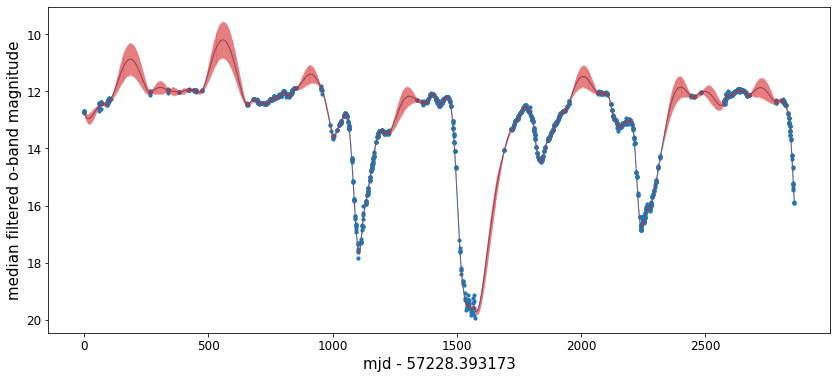

In [213]:
plt.figure(figsize=(14,6))

plt.plot(x_pred,y_pred)
plt.errorbar(x_pred, y_pred, yerr=sigma, capsize=0, color='tab:red',alpha=0.2)

plt.scatter(median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m'],s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('median filtered o-band magnitude')
# plt.xlim(1000,3000)
plt.show()

In [197]:
gpsmoothed_time = time
gpsmoothed_flux, gpsigma = gp.predict(gpsmoothed_time, return_std=True)

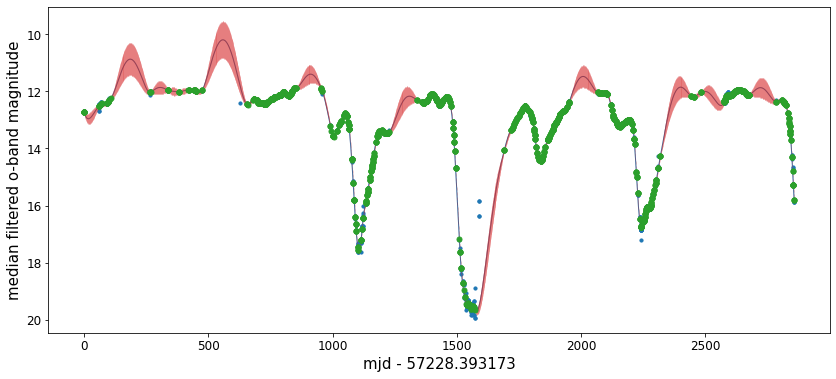

In [134]:
plt.figure(figsize=(14,6))

plt.plot(x_pred,y_pred)
plt.errorbar(x_pred, y_pred, yerr=sigma, capsize=0, color='tab:red',alpha=0.2)

plt.scatter(gpsmoothed_time,gpsmoothed_flux,color='tab:green',zorder=3)

plt.scatter(oband['mjd']-oband['mjd'][0],median_filtered,s=10)
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('median filtered o-band magnitude')
# plt.xlim(1000,3000)
plt.show()

In [42]:
gp_edge_detect = sp.ndimage.convolve(y_pred, [1.0, 0.0, -1.0])

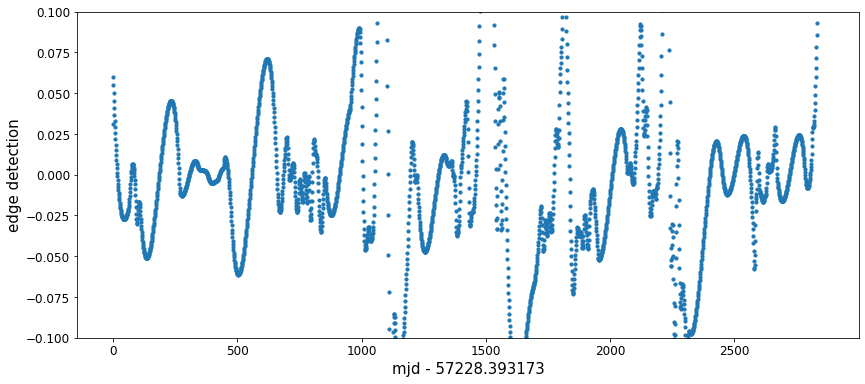

In [43]:
# np.std()

plt.figure(figsize=(14,6))
plt.scatter(x_pred,gp_edge_detect,s=10)
# plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(oband['mjd'][0]))
plt.ylabel('edge detection')
plt.ylim(-0.1,0.1)
plt.show()

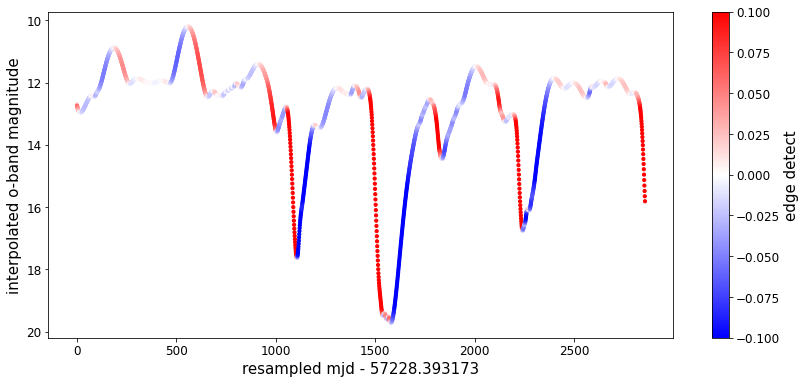

In [44]:
plt.figure(figsize=(14,6))
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.scatter(x_pred,y_pred,s=10,
            c=gp_edge_detect,cmap='bwr')#,alpha=0.2)
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.gca().invert_yaxis()
plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
plt.ylabel('interpolated o-band magnitude')
plt.colorbar(label='edge detect')
# plt.clim(vmax=-1)
# plt.clim(vmin=-1)
plt.clim(-0.1,0.1)
# lim = np.max([np.abs(np.min(new_edge_detect)),np.max(new_edge_detect)])
# plt.clim(-lim,lim)
# plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
plt.show()

In [45]:
## interpolate the edge detection to convert back to the original times
# np.linspace(0, int(np.max(time)), int(np.max(time)))
gp_edgedetect_interp = sp.interpolate.interp1d(x_pred[:,0],
                                                 gp_edge_detect,
                                                 kind='slinear')

gp_edges = gp_edgedetect_interp(median_filtered_oband['mjd']-mjd_scale)

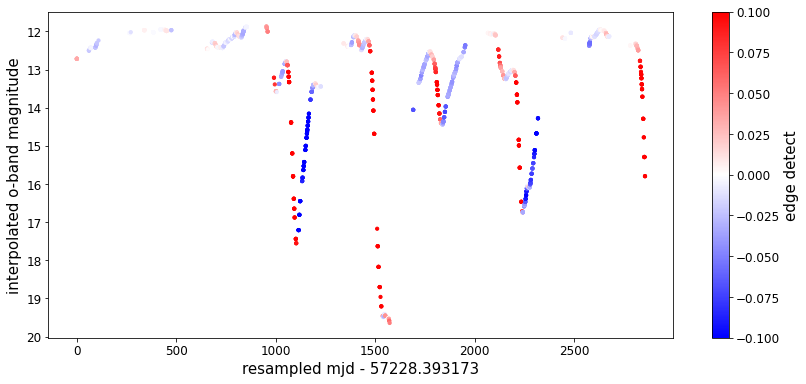

In [46]:
plt.figure(figsize=(14,6))
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.scatter(gpsmoothed_time,gpsmoothed_flux,s=10,
            c=gp_edges,cmap='bwr')#,alpha=0.2)
# plt.scatter(resample_time,(new_edge_detect+3)*4,s=10)
plt.gca().invert_yaxis()
plt.xlabel('resampled mjd - '+str(oband['mjd'][0]))
plt.ylabel('interpolated o-band magnitude')
plt.colorbar(label='edge detect')
# plt.clim(vmax=-1)
# plt.clim(vmin=-1)
plt.clim(-0.1,0.1)
# lim = np.max([np.abs(np.min(new_edge_detect)),np.max(new_edge_detect)])
# plt.clim(-lim,lim)
# plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
plt.show()

# Now back to normal

In [47]:
## interpolate the edge detection to convert back to the original times
# edge_detect_interp_func = sp.interpolate.interp1d(resample_time,
#                                                  new_edge_detect,
#                                                  kind='slinear')

# edges_realdata = edge_detect_interp_func(median_filtered_oband['mjd']-mjd_scale)


In [64]:
# plt.figure(figsize=(14,6))
# plt.scatter(median_filtered_oband['mjd']-mjd_scale,edges_realdata,s=10)
# # plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(mjd_scale))
# plt.ylabel('edge detect back to real data')
# # plt.colorbar(label='edge detect')
# # plt.clim(vmax=-1)
# # plt.clim(vmin=-1)
# # plt.clim(-1,1)
# plt.show()

In [65]:
# plt.figure(figsize=(14,6))
# # plt.scatter(oband['mjd'][mask]-oband['mjd'][0],(edges_realdata+3)*4,s=10)
# plt.scatter(median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m'],s=10,
#             c=(edges_realdata),cmap='bwr')
# plt.gca().invert_yaxis()
# plt.xlabel('mjd - '+str(mjd_scale))
# plt.ylabel('median filtered o-band magnitude')
# plt.colorbar(label='edge detect')
# # plt.clim(vmax=-1)
# # plt.clim(vmin=-1)
# plt.clim(-0.1,0.1)
# # plt.xlim(950,1200)
# # plt.xlim(500,1000)
# # plt.savefig('/Users/ccra8514/Desktop/edge_detect',bbox_inches='tight')
# plt.show()

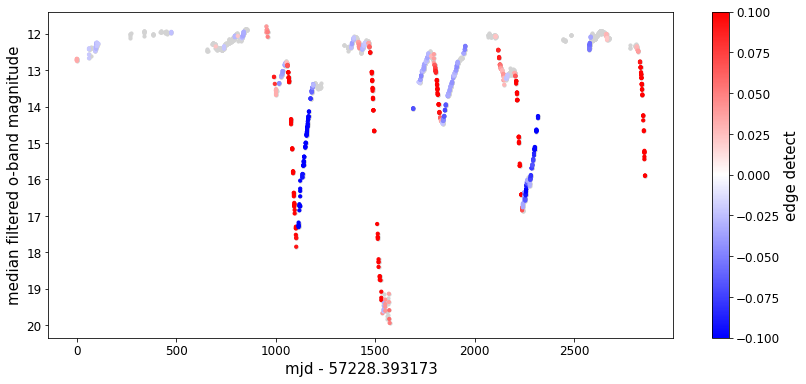

In [50]:
std_dev = np.std(gp_edges)
# std_dev
new_mask = np.where(np.abs(gp_edges)>(std_dev*0.25),True,False)

plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd'][mask]-oband['mjd'][0],(gp_edges+3)*4,s=10)
plt.scatter(median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m'],s=10,color='lightgrey')
plt.scatter(median_filtered_oband['mjd'][new_mask]-mjd_scale,median_filtered_oband['m'][new_mask],s=10,
            c=(gp_edges[new_mask]),cmap='bwr')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('median filtered o-band magnitude')
plt.colorbar(label='edge detect')
plt.clim(-0.1,0.1)
# plt.xlim(950,1200)
# plt.xlim(500,1000)
plt.show()

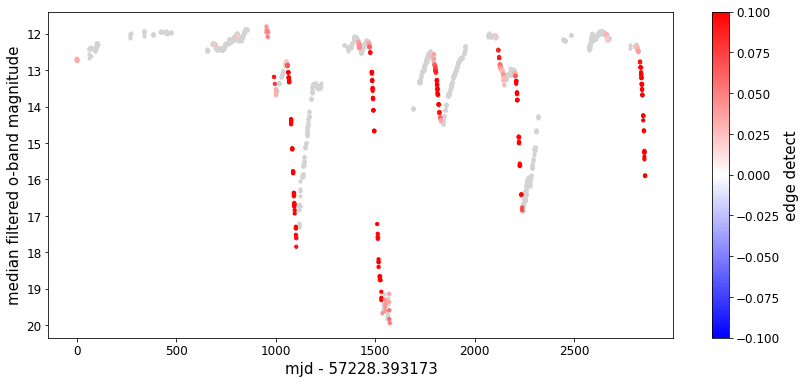

In [51]:
std_dev = np.std(gp_edges)
new_mask = np.where(np.abs(gp_edges)>(std_dev*0.25),True,False)
downslope_mask = np.where(gp_edges>0.0,True,False)
total_mask = new_mask & downslope_mask

plt.figure(figsize=(14,6))
# plt.scatter(oband['mjd'][mask]-oband['mjd'][0],(gp_edges+3)*4,s=10)
plt.scatter(median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m'],s=10,color='lightgrey')
plt.scatter(median_filtered_oband['mjd'][total_mask]-mjd_scale,median_filtered_oband['m'][total_mask],s=10,
            c=(gp_edges[total_mask]),cmap='bwr')
plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('median filtered o-band magnitude')
plt.colorbar(label='edge detect')
plt.clim(-0.1,0.1)
# plt.xlim(950,1200)
# plt.xlim(500,1000)
plt.show()

In [52]:
print(median_filtered_oband['mjd'][total_mask]-mjd_scale)

0          0.000000
1          0.011003
2          0.026038
3          0.036302
4          0.058426
           ...     
1738    2853.921725
1739    2853.937907
1740    2856.891383
1741    2856.893185
1742    2856.896789
Name: mjd, Length: 407, dtype: float64


In [53]:
def find_runs(x):
    x = np.asanyarray(x)
    n = x.shape[0]
    
    # find run starts
    loc_run_start = np.empty(n, dtype=bool)
    loc_run_start[0] = True
    np.not_equal(x[:-1], x[1:], out=loc_run_start[1:])
    run_starts = np.nonzero(loc_run_start)[0]

    # find run values
    run_values = x[loc_run_start]

    # find run lengths
    run_lengths = np.diff(np.append(run_starts, n))

    return run_values, run_starts, run_lengths

In [54]:
run_vals, run_start, run_length = find_runs(total_mask)

In [55]:
downward_mask = run_start[np.logical_and(run_vals==True,run_length > 3)]
upward_mask = run_start[np.logical_and(run_vals==False,run_length > 3)]

In [56]:
median_filtered_oband['mjd'][downward_mask]-mjd_scale

0          0.000000
313      953.242785
366     1055.101878
640     1415.147358
711     1467.000975
776     1550.863938
786     1568.818974
881     1783.132147
894     1795.015133
1144    2105.178317
1294    2201.035698
1635    2660.656290
1678    2814.985109
Name: mjd, dtype: float64

In [57]:
median_filtered_oband['mjd'][run_start]

0       57228.393173
8       57289.276473
109     57926.489282
110     57930.495579
257     58037.289013
258     58039.269530
313     58181.635958
333     58233.573266
366     58283.495051
432     58343.382065
640     58643.540531
664     58657.560876
711     58695.394148
765     58769.275694
776     58779.257111
780     58787.261345
786     58797.212147
791     58919.625949
881     59011.525320
885     59015.475462
894     59023.408306
946     59067.472874
1144    59333.571490
1190    59385.487983
1294    59429.428871
1336    59469.322207
1635    59889.049463
1650    59897.027001
1678    60043.378282
Name: mjd, dtype: float64

In [58]:
median_filtered_oband['m'][run_start]

0       12.691
8       12.675
109     12.353
110     12.400
257     12.066
258     12.080
313     11.970
333     13.573
366     12.795
432     17.277
640     12.240
664     12.520
711     12.263
765     19.435
776     19.491
780     19.732
786     19.131
791     14.054
881     12.625
885     12.675
894     12.684
946     14.446
1144    12.076
1190    13.234
1294    13.087
1336    16.863
1635    12.022
1650    12.141
1678    12.354
Name: m, dtype: float64

In [59]:
decline_onset = []
decline_end = []
for i in range(0,len(median_filtered_oband['m'][run_start])):
    if i == 0 and np.abs(median_filtered_oband['m'].iloc[0] - median_filtered_oband['m'][run_start[i+1]]) > 0.8:
        ## adding the absolute magnitude should detect beginning declines
        ## NEEDS TO BE TESTED
        decline_onset.append(0)
        print('beginning')
        print('0')
        print(median_filtered_oband['mjd'][0])
        print(np.abs(median_filtered_oband['m'].iloc[0] - median_filtered_oband['m'][run_start[i]]))
    elif i == len(median_filtered_oband['m'][run_start])-1:
        if median_filtered_oband['m'].iloc[-1] - median_filtered_oband['m'][run_start[i]] > 0.8:
            decline_onset.append(run_start[i])
            print('end')
            print(run_start[i])
            print(median_filtered_oband['mjd'][run_start[i]])
            print(median_filtered_oband['m'].iloc[-1] - median_filtered_oband['m'][run_start[i]])
    elif median_filtered_oband['m'][run_start[i+1]] - median_filtered_oband['m'][run_start[i]] > 0.8:#1:
        decline_onset.append(run_start[i])
        print(run_start[i])
        print(median_filtered_oband['mjd'][run_start[i]])
        print(median_filtered_oband['m'][run_start[i+1]] - median_filtered_oband['m'][run_start[i]])
#     if i == len(median_filtered_oband['m'][run_start]):
#         print('end')

313
58181.635958
1.6029999999999998
366
58283.495051
4.482000000000001
711
58695.394148
7.171999999999999
894
59023.408306
1.7620000000000005
1144
59333.57149
1.1579999999999995
1294
59429.428871
3.776
end
1678
60043.378282
3.537000000000001


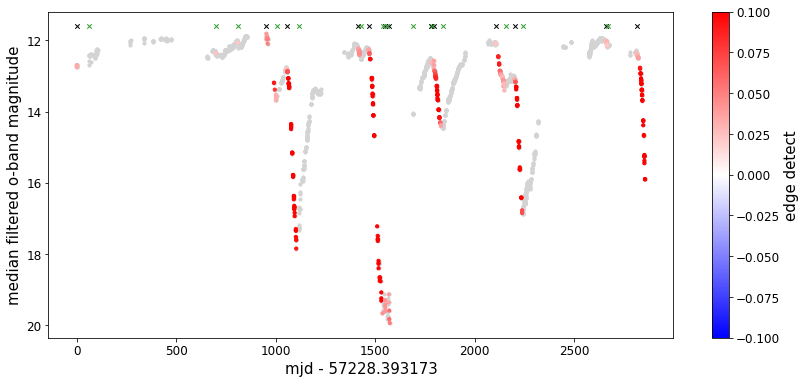

In [62]:
plt.figure(figsize=(14,6))
plt.scatter(median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m'],s=10,color='lightgrey')
plt.scatter(median_filtered_oband['mjd'][downward_mask]-mjd_scale,
            np.full(len(median_filtered_oband['mjd'][downward_mask]),np.min(median_filtered_oband['m']))-0.2
                    ,s=20,marker='x',color='k',zorder=3)
plt.scatter(median_filtered_oband['mjd'][upward_mask]-mjd_scale,
            np.full(len(median_filtered_oband['mjd'][upward_mask]),np.min(median_filtered_oband['m']))-0.2
                    ,s=20,marker='x',color='tab:green',zorder=3)
# plt.scatter(median_filtered_oband['mjd'][decline_onset]-mjd_scale,
#             np.full(len(median_filtered_oband['mjd'][decline_onset]),np.min(median_filtered_oband['m']))-0.2,
#                     s=20,marker='x',color='k',zorder=3)
plt.scatter(median_filtered_oband['mjd'][total_mask]-mjd_scale,median_filtered_oband['m'][total_mask],s=10,
            c=(gp_edges[total_mask]),cmap='bwr')

plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('median filtered o-band magnitude')
plt.colorbar(label='edge detect')
plt.clim(-0.1,0.1)
plt.show()

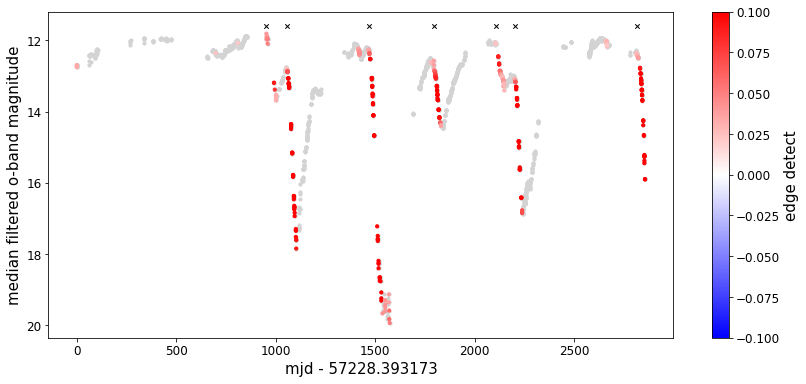

In [63]:
plt.figure(figsize=(14,6))
plt.scatter(median_filtered_oband['mjd']-mjd_scale,median_filtered_oband['m'],s=10,color='lightgrey')
# plt.scatter(median_filtered_oband['mjd'][downward_mask]-mjd_scale,
#             np.full(len(median_filtered_oband['mjd'][downward_mask]),np.min(median_filtered_oband['m']))-0.2
#                     ,s=20,marker='x',color='k',zorder=3)
# plt.scatter(median_filtered_oband['mjd'][upward_mask]-mjd_scale,
#             np.full(len(median_filtered_oband['mjd'][upward_mask]),np.min(median_filtered_oband['m']))-0.2
#                     ,s=20,marker='x',color='tab:green',zorder=3)
plt.scatter(median_filtered_oband['mjd'][decline_onset]-mjd_scale,
            np.full(len(median_filtered_oband['mjd'][decline_onset]),np.min(median_filtered_oband['m']))-0.2,
                    s=20,marker='x',color='k',zorder=3)
plt.scatter(median_filtered_oband['mjd'][total_mask]-mjd_scale,median_filtered_oband['m'][total_mask],s=10,
            c=(gp_edges[total_mask]),cmap='bwr')

plt.gca().invert_yaxis()
plt.xlabel('mjd - '+str(mjd_scale))
plt.ylabel('median filtered o-band magnitude')
plt.colorbar(label='edge detect')
plt.clim(-0.1,0.1)
# plt.savefig('/Users/ccra8514/Desktop/decline_detect',bbox_inches='tight')
plt.show()